In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

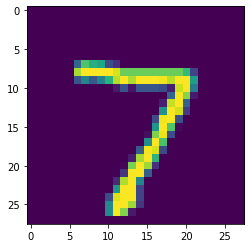

In [3]:
plt.imshow(x_test[0])

In [4]:
train_images = x_train[:6000]
train_labels = y_train[:6000]

In [5]:
test_images = x_test[:6000]
test_labels = y_test[:6000]

In [6]:
n_filter=8
h_filter=3
w_filter=3
strip=1
final_nodes = 10
learning_rate = 0.005

In [7]:
h_image,w_image=x_train[0].shape
h_cov = int(np.floor(h_image - h_filter)/strip+1)
w_cov = int(np.floor(w_image - h_filter)/strip+1)
h_maxpool = int(h_cov/2)
w_maxpool = int(w_cov/2)

In [8]:
filters = np.random.randn(n_filter, h_filter, w_filter)
filters = filters / 10
final_weights = np.random.randn(h_maxpool*w_maxpool*n_filter, final_nodes) / h_maxpool*w_maxpool*n_filter
final_weights = final_weights/1000
final_biases = np.zeros(final_nodes)

In [9]:
def iterate1(initial_image):
    for i in range(h_cov):
        for j in range(w_cov):
            focus_block = initial_image[i:(i + 3), j:(j + 3)]
            yield focus_block, i, j
            

In [10]:
#Initialize the weightes in convulutional layers
def Conv_layer_forward (initial_image):
    global filters
    
    output1 = np.zeros((h_cov, w_cov, n_filter))
    #forward caculation
    for focus_block, i, j in iterate1 (initial_image):
        output1[i, j] = np.sum(focus_block * filters, axis=(1, 2))
    return output1

In [11]:
def Conv_layer_backward (maxpool_resume_derivative,initial_image):
    global filters
    
    filters_derivative = np.zeros(filters.shape)
    for focus_block, i, j in iterate1(initial_image):
        for f in range(n_filter):
            filters_derivative[f] += maxpool_resume_derivative[i, j, f] * focus_block
    
    
    filters -= learning_rate * filters_derivative

In [12]:
def iterate2(conv_image):
    for i in range(h_maxpool):
        for j in range(w_maxpool):
            reduced_block = conv_image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
            yield reduced_block, i, j

In [13]:
#max pool
def Maxpool_layer_forward (conv_image):
    output2 = np.zeros((h_maxpool,w_maxpool, n_filter))
    for reduced_block, i, j in iterate2(conv_image):
        output2[i, j] = np.amax(reduced_block, axis=(0, 1))
    return output2

In [14]:
def Maxpool_layer_backward (maxpool_derivative,conv_output):
    maxpool_resume_derivative = np.zeros(conv_output.shape)
    for reduced_block, i, j in iterate2(conv_output):
        h, w, f = reduced_block.shape
        amax = np.amax(reduced_block, axis=(0, 1))
        for i2 in range(h):
            for j2 in range(w):
                for f2 in range(f):
                    # If this pixel was the max value, copy the gradient to it.
                    if reduced_block[i2, j2, f2] == amax[f2]:
                        maxpool_resume_derivative[i + i2, j + j2, f2] = maxpool_derivative[i, j, f2]
    return maxpool_resume_derivative


In [15]:
#softmax on final layer
def Softmax_layer_forward (image):
    
    global final_weights, final_biases
    final_input=image.flatten()
  #  input_len, nodes = final_weights.shape
    totals = np.dot(final_input, final_weights) + final_biases 
    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0),totals

In [16]:
def Softmax_layer_backward (cost_derivative,totals,maxpool_output):
    input_shape = maxpool_output.shape
    for i, gradient in enumerate(cost_derivative):
        if gradient == 0:
            continue
        total_exp = np.exp(totals) 
        Sum = np.sum(total_exp)
        softmax_derivative = -total_exp[i] * total_exp / (Sum ** 2)
        softmax_derivative[i] = total_exp[i] * (Sum - total_exp[i]) / (Sum ** 2)
        
        activation_derivative= maxpool_output.flatten()
        
        global final_weights, final_biases
        
        sofmax_gradients = final_weights
        adjustment = gradient * softmax_derivative
        
        maxpool_output = maxpool_output.flatten()
        
        weight_derivative = maxpool_output[np.newaxis].T @ adjustment[np.newaxis]
        bias_derivative = adjustment * 1
        maxpool_derivative = final_weights @ adjustment
        
        
        final_weights -= learning_rate * weight_derivative
        final_biases -= learning_rate * bias_derivative
        
        return maxpool_derivative.reshape(input_shape)


In [17]:
#train data 
match_list = []
miss_list = []
loss_list = []

for epoch in range(3):
    permutation = np.random.permutation(1000)
    train_image = train_images[permutation]
    train_label = train_labels[permutation]
    match = 0
    miss = 0
    
    for i, (image, label) in enumerate(zip(train_image, train_label)):
        conv_output = Conv_layer_forward ((image/255) - 0.5)
        maxpool_output = Maxpool_layer_forward (conv_output)
        final_output,totals = Softmax_layer_forward (maxpool_output)
        loss = -np.log(final_output[label])
        loss +=loss
        
        #start gradient descent training 
        cost_derivative = np.zeros(10)
        cost_derivative[label] = -1 / final_output[label]
        
        maxpool_derivative = Softmax_layer_backward(cost_derivative,totals,maxpool_output)
        maxpool_resume_derivative = Maxpool_layer_backward(maxpool_derivative,conv_output)
        Conv_layer_backward(maxpool_resume_derivative,(image/255) - 0.5)
        if np.argmax(final_output) == label:
            match +=1
        else:
            miss +=1
            
    match_list.append(match)
    miss_list.append(miss)
    loss_list.append(loss)

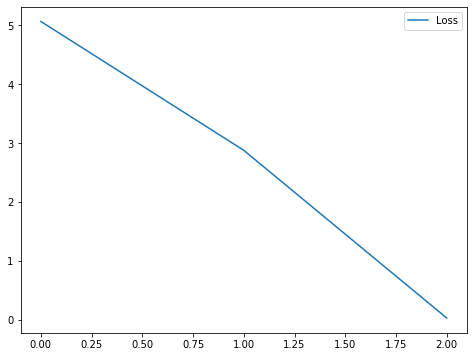

In [18]:
plt.figure(figsize=(8,6))
plt.plot(loss_list,label='Loss')
plt.legend()

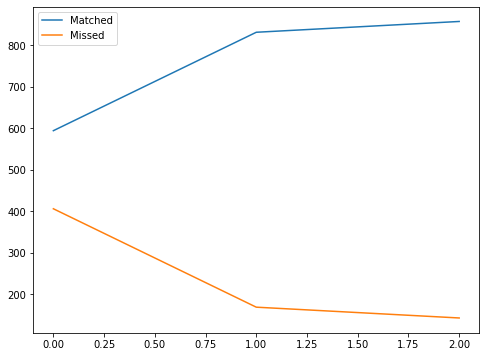

In [19]:
plt.figure(figsize=(8,6))
plt.plot(match_list,label='Matched')
plt.plot(miss_list,label='Missed')
plt.legend()

In [20]:
# test data 
match = 0
miss = 0
for i, (image, label) in enumerate(zip(test_images, test_labels)):
    # Standarlize image from [0, 255] to [-0.5, 0.5] 
    conv_output = Conv_layer_forward ((image/255) - 0.5)
    maxpool_output = Maxpool_layer_forward (conv_output)
    final_output,totals = Softmax_layer_forward (maxpool_output)
    loss = -np.log(final_output[label])
    loss +=loss
    if np.argmax(final_output) == label:
        match +=1
    else:
        miss +=1

print("Matched: ",match)
print("Missed: ",miss)

Matched:  4929
Missed:  1071
